# Run ephys element workflow

This notebook walks you through the steps to run the ephys workflow.  
The workflow requires neuropixels meta file and kilosort output data.  
A typical organization of the files is as follows:  

```
root_data_dir/
└───subject1/
│   └───session0/
│   │   └───imec0/
│   │   │   │   *imec0.ap.meta
│   │   │   └───ksdir/
│   │   │       │   spike_times.npy
│   │   │       │   templates.npy
│   │   │       │   ...
│   │   └───imec1/
│   │       │   *imec1.ap.meta   
│   │       └───ksdir/
│   │           │   spike_times.npy
│   │           │   templates.npy
│   │           │   ...
│   └───session1/
│   │   │   ...
└───subject2/
│   │   ...
```



Let's start by importing the relevant modules.

In [2]:
import datetime
import pathlib
import numpy as np
import pylab as pl

import os
os.chdir('../..')

from u19_pipeline import acquisition, ephys
from u19_pipeline.ephys import ephys_element, probe_element
import datajoint as dj

Connecting ms81@datajoint00.pni.princeton.edu:3306


The module ephys_element contains all the tables designed in the DataJoint ephys element, we could draw the diagram to see the schema structures

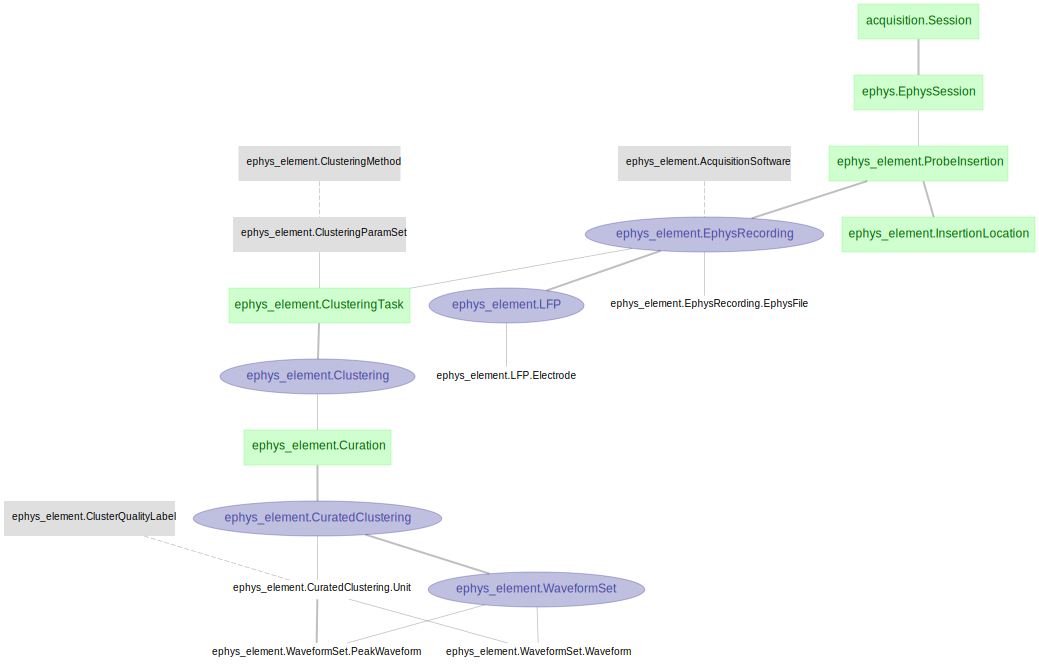

In [2]:
dj.Diagram(acquisition.Session) + ephys.EphysSession + dj.Diagram(ephys_element)

## Ingest Probe and ProbeInsertion by ephys_element_ingest

The original U19 pipeline contains a table `ephys.EphysSession` where datapath to the neuropixel meta file and the kilosort output folder were stored.

In [3]:
ephys.EphysSession() # Current sessions

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,ephys_directory Path were session file will be stored in bucket
hnieh_E105,2021-01-15,0,/mnt/bucket/labs/tank/schottdorf/NPX/2021_01_15_E105/towersTask_g0


In [5]:
# Do you have a new one to insert? This is how it is done:

key = {
    'subject_fullname': 'ms81_M004',
    'session_date': datetime.date(2021, 5, 7),
    'session_number': 0,
    'ephys_directory': '/Users/ms81/project_Neuropixel/analyses/data/210507_M004/'
}

ephys.EphysSession.insert1(key, skip_duplicates=True) # insert1 only works for one entry
ephys.EphysSession()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,ephys_directory Path were session file will be stored in bucket
hnieh_E105,2021-01-15,0,/Volumes/Tank/schottdorf/NPX/2021_01_15_E105/towersTask_g0
ms81_M004,2021-05-07,0,/Users/ms81/project_Neuropixel/analyses/data/210507_M004/


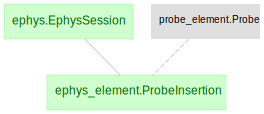

In [19]:
dj.Diagram(ephys.EphysSession) + dj.Diagram(probe_element.Probe) + dj.Diagram(ephys_element.ProbeInsertion)

A module `ephys_element_ingest` was provided to process a ephys session based on the neuropixel meta file: ingest entries into tables `Probe` and `ProbeInsertion`

In [4]:
from u19_pipeline.ingest import ephys_element_ingest

In [5]:
for sess_key in ephys.EphysSession.fetch('KEY'):
    ephys_element_ingest.process_session(sess_key)

In [6]:
probe_element.Probe()

probe unique identifier for this model of probe (e.g. part number),probe_type e.g. neuropixels_1.0,probe_comment
17131311651,neuropixels 1.0 - 3B,


In [8]:
ephys_element.ProbeInsertion()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,probe unique identifier for this model of probe (e.g. part number)
hnieh_E105,2021-01-15,0,0,17131311651


## Populate EphysRecording

By populating `ephys_element.EphysRecording`, three tables will be ingested:
+ `probe_element.EelectrodeConfig` table contains the configuration information of the electrodes used, i.e. which 384 electrodes out of the total 960 on the probe were used in this ephys session
+ `ephys_element.EphysRecording` table specifies which ElectrodeConfig is used in a particular ephys session
+ `ephys_element.EphysRecording.EphysFile` table saves the file path of SpikeGLX meta file.

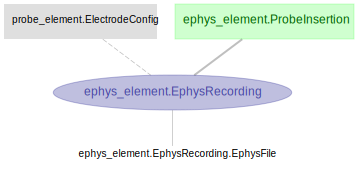

In [22]:
dj.Diagram(ephys_element.ProbeInsertion) + probe_element.ElectrodeConfig\
+ ephys_element.EphysRecording + ephys_element.EphysRecording.EphysFile

In [23]:
ephys_element.EphysRecording()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz)
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,SpikeGLX,30000.6


In [10]:
ephys_element.EphysRecording.populate(display_progress=True)

EphysRecording: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


Here is an overview of the Electrode used in a EphysRecording for a particular probe insertion

In [11]:
probe_insertion_key = ephys_element.ProbeInsertion.fetch('KEY', limit=1)[0]
ephys_element.EphysRecording * probe_element.ElectrodeConfig.Electrode & probe_insertion_key

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",acq_software,sampling_rate (Hz)
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,SpikeGLX,30000.6
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,1,SpikeGLX,30000.6
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2,SpikeGLX,30000.6
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,3,SpikeGLX,30000.6
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4,SpikeGLX,30000.6
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5,SpikeGLX,30000.6
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,SpikeGLX,30000.6
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,7,SpikeGLX,30000.6
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,8,SpikeGLX,30000.6
hnieh_E105,2021-01-15,0,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,9,SpikeGLX,30000.6


In [13]:
ephys_element.EphysRecording.EphysFile()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,file_path filepath relative to root data directory
hnieh_E105,2021-01-15,0,0,schottdorf/NPX/2021_01_15_E105/towersTask_g0/towersTask_g0_imec0/towersTask_g0_t0.imec0.ap.meta


Note that the filepath is a relative path to the `ephys_root_data_dir` in `dj.config['custom']`

## Populate clustering results

The next major table in the ephys pipeline is the `ClusteringTask`, which is a manual table that is inserted when a Kilosort2 clustering task is finished and the clustering results are ready for processing. The `ClusteringTask` table depends on the table `ClusteringParamSet`, which are the parameters of the clustering task and needed to be inserted first. A method of the class `ClusteringParamSet` called `insert_new_params` helps on the insertion of params_set

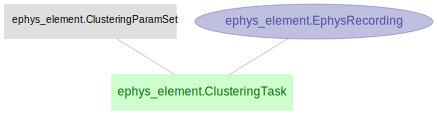

In [24]:
dj.Diagram(ephys_element.EphysRecording) + ephys_element.ClusteringParamSet + ephys_element.ClusteringTask

In [16]:
# insert clustering task manually
params_ks = {
    "fs": 30000,
    "fshigh": 150,
    "minfr_goodchannels": 0.1,
    "Th": [10, 4],
    "lam": 10,
    "AUCsplit": 0.9,
    "minFR": 0.02,
    "momentum": [20, 400],
    "sigmaMask": 30,
    "ThPr": 8,
    "spkTh": -6,
    "reorder": 1,
    "nskip": 25,
    "GPU": 1,
    "Nfilt": 1024,
    "nfilt_factor": 4,
    "ntbuff": 64,
    "whiteningRange": 32,
    "nSkipCov": 25,
    "scaleproc": 200,
    "nPCs": 3,
    "useRAM": 0
}
ephys_element.ClusteringParamSet.insert_new_params(
    'kilosort2', 0, 'Spike sorting using Kilosort2', params_ks)
ephys_element.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,83f93e90-d8e0-1dca-5b2c-f65e2b0b3c61,=BLOB=


We are then able to insert an entry into the `ClusteringTask` table. One important field of the table is `clustering_output_dir`, which specifies the Kilosort2 output directory for the later processing. For the current pipeline, the directory could be reconstructed from directories stored in existing tables

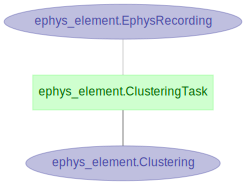

In [26]:
dj.Diagram(ephys_element.EphysRecording) + ephys_element.ClusteringTask + ephys_element.Clustering

In [27]:
ephys_element.ClusteringTask.describe();

# Manual table for defining a clustering task ready to be run
-> ephys_element.EphysRecording
-> ephys_element.ClusteringParamSet
---
clustering_output_dir : varchar(255)                 # clustering output directory relative to the clustering root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation



In [28]:
# Specify path and animal information

ephys_key = dict(
    subject_fullname='ms81_M004', session_date='2021-05-07', session_number=0, insertion_number=0)
ephys_dir = '210507_M004/towersTask_g0_imec0/'

In [29]:
ephys_element.ClusteringTask.insert1(
    dict(**ephys_key, paramset_idx=0, clustering_output_dir=ephys_dir), skip_duplicates=True)
ephys_element.ClusteringTask()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,paramset_idx,clustering_output_dir clustering output directory relative to the clustering root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
hnieh_E105,2021-01-15,0,0,0,schottdorf/NPX/2021_01_15_E105/towersTask_g0/towersTask_g0_imec0,load


We are then able to populate the clustering results. The `Clustering` table now validates the Kilosort2 outcomes. In the future release of elements-ephys, this table will be used to trigger Kilosort2.

In [31]:
ephys_element.Clustering.populate(display_progress=True)

Clustering: 100%|██████████| 1/1 [00:00<00:00, 51.88it/s]


# Curation and CuratedClustering

The next step in the pipeline is the curation of spike sorting results. If a manual curation was implemented, an entry needs to be manually inserted into the table `Curation`, which specifies the directory to the curated results in `curation_output_dir`. If we would like to process the Kilosort2 outcome directly, an entry is also needed in `Curation`. A method `create1_from_clustering_task` was provided to help this insertion. It copies the `clustering_output_dir` in `ClusteringTask` to the field `curation_output_dir` in the table `Curation` with a new `curation_id`.

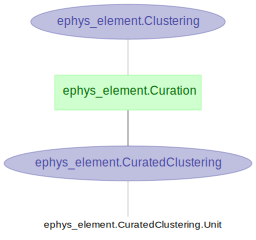

In [38]:
dj.Diagram(ephys_element.Clustering) + ephys_element.Curation + ephys_element.CuratedClustering \
+ ephys_element.CuratedClustering.Unit

In [32]:
key = (ephys_element.ClusteringTask & ephys_key).fetch1('KEY')
ephys_element.Curation().create1_from_clustering_task(key)

In [33]:
ephys_element.Curation()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,paramset_idx,curation_id,curation_time time of generation of this set of curated clustering results,"curation_output_dir output directory of the curated results, relative to clustering root data directory",quality_control has this clustering result undergone quality control?,manual_curation has manual curation been performed on this clustering result?,curation_note
hnieh_E105,2021-01-15,0,0,0,1,2021-02-21 23:43:45,schottdorf/NPX/2021_01_15_E105/towersTask_g0/towersTask_g0_imec0,0,0,


Then we could populate table `CuratedClustering`, ingesting either the output of Kilosort2 or the curated results.

In [34]:
ephys_element.CuratedClustering.populate(display_progress=True)

CuratedClustering: 100%|██████████| 1/1 [00:08<00:00,  8.14s/it]


The part table `CuratedClustering.Unit` contains the spike sorted units

In [39]:
ephys_element.CuratedClustering.Unit()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,paramset_idx,curation_id,unit,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0",cluster_quality_label,spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording",spike_sites array of electrode associated with each spike,"spike_depths (um) array of depths associated with each spike, relative to the (0, 0) of the probe"
hnieh_E105,2021-01-15,0,0,0,1,0,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,mua,1227,=BLOB=,=BLOB=,=BLOB=
hnieh_E105,2021-01-15,0,0,0,1,1,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,0,mua,9390,=BLOB=,=BLOB=,=BLOB=
hnieh_E105,2021-01-15,0,0,0,1,2,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,2,mua,34,=BLOB=,=BLOB=,=BLOB=
hnieh_E105,2021-01-15,0,0,0,1,3,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,4,mua,4393,=BLOB=,=BLOB=,=BLOB=
hnieh_E105,2021-01-15,0,0,0,1,4,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,5,mua,5535,=BLOB=,=BLOB=,=BLOB=
hnieh_E105,2021-01-15,0,0,0,1,5,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,mua,20133,=BLOB=,=BLOB=,=BLOB=
hnieh_E105,2021-01-15,0,0,0,1,6,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,6,good,8519,=BLOB=,=BLOB=,=BLOB=
hnieh_E105,2021-01-15,0,0,0,1,7,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,8,good,10475,=BLOB=,=BLOB=,=BLOB=
hnieh_E105,2021-01-15,0,0,0,1,8,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,9,mua,212,=BLOB=,=BLOB=,=BLOB=
hnieh_E105,2021-01-15,0,0,0,1,9,6f6d8149-1603-9d2c-f884-0fdf995ec8b3,neuropixels 1.0 - 3B,11,good,30,=BLOB=,=BLOB=,=BLOB=


## Populate LFP and waveform

In [40]:
ephys_element.LFP.populate(display_progress=True)

LFP: 100%|██████████| 1/1 [01:55<00:00, 115.83s/it]


In [41]:
ephys_element.LFP()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,lfp_sampling_rate (Hz),lfp_time_stamps (s) timestamps with respect to the start of the recording (recording_timestamp),"lfp_mean (uV) mean of LFP across electrodes - shape (time,)"
hnieh_E105,2021-01-15,0,0,2500.05,=BLOB=,=BLOB=


The current workflow also contain tables to save spike waveforms:

`WaveformSet`: a table to drive the processing of all spikes waveforms resulting from a CuratedClustering.  
`WaveformSet.Waveform`: mean waveform across spikes for a given unit and electrode.  
`WaveformSet.PeakWaveform`: mean waveform across spikes for a given unit at the electrode with peak spike amplitude.

In [2]:
# May take a while to populate depending on data size.
ephys_element.WaveformSet.populate(display_progress=True)

WaveformSet: 100%|██████████| 1/1 [20:01<00:00, 1201.35s/it]


# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

In [6]:
ephys.BehaviorSync.populate()

Once the synchronization files have been produces, the all Clusters/spikes can be binned into iterations.

In [7]:
ephys.CuratedClustersIteration.populate()

This allows to plot neuronal responses responses. Here is an example

In [9]:
key = {"subject_fullname": "ms81_M004", "insertion_number": 0, "session_date": '2021-05-07', 'curation_id': 1}

ephys.BehaviorSync() & key

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,nidq_sampling_rate sampling rate of behavioral iterations niSampRate in nidq meta file,iteration_index_nidq length of this longblob should be the number of iterations in the behavior recording,trial_index_nidq length of this longblob should be the number of iterations in the behavior recording
ms81_M004,2021-05-07,0,5000.06,=BLOB=,=BLOB=


In [10]:
spikes = (ephys.CuratedClustersIteration.Unit & key & 'unit = 7').fetch1('spike_counts_iteration')

behavior = dj.create_virtual_module('subject', 'u19_behavior')
pos, time = (behavior.TowersBlock().Trial() & key).fetch('position', 'trial_time')

position_at_each_iteration = []
for trial in range(len(pos)):
    pp = pos[trial][:,1]
    snip = np.zeros(len(time[trial]))*np.NaN
    snip[0:len(pp)] = pp
    position_at_each_iteration = np.append(position_at_each_iteration, snip)

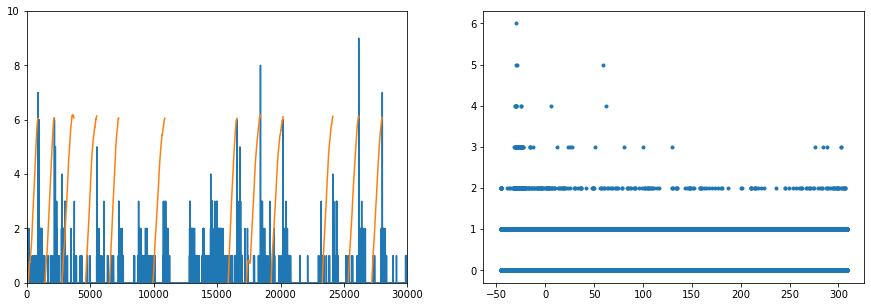

In [11]:
pl.figure(figsize=(15,5))
pl.subplot(1,2,1)
pl.plot(spikes)
pl.plot(position_at_each_iteration/50)
pl.ylim([0,10])
pl.xlim([0,30000])

pl.subplot(1,2,2)
pl.plot(position_at_each_iteration[1:], spikes, '.')

TODO: 
    - Sync table under ephys module.
    - Unit table could contain the clustering results for multiple sorters. U19 team needs to implemnt the workflow for other sorters by overwriting the make function of the table `ephys_element.Clustering`. e.g.
    ```
    def ironclust_make(key):
    if (ephys_element.ClusteringMethod & key).fetch1('clustering_method') != 'ironclust':
        return
    pass
    ephys_element.CuratedClustering.make = ironclust_make
    ephys_element.CuratedClustering.populate()
    ```